# Deterministic Artificial Traders

In [1]:
from atom import *
from math import sqrt
import numpy as np
from numpy import linspace, log
from numpy.random import normal, laplace, randint, uniform
import data_processing as dp
import matplotlib.pyplot as plt
from numpy import mean
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (15,10)

## DAT Fundamentalist (DAT-F)

In [2]:
class DAT_F(Trader):
	def __init__(self, market, aggressiveness, self_confidence, fv, initial_assets=None, cash=0):
		Trader.__init__(self, market, initial_assets, cash)
		self.alpha = aggressiveness
		self.kappa = self_confidence
		self.fv = fv
	def __str__(self):
		return "DAT-F %i" % self.trader_id
	def decide_order(self, market, asset):
		p = market.prices[asset]
		m = self.fv
		best_ask = market.orderbooks[asset].asks.root().price if market.orderbooks[asset].asks.size > 0 else None
		best_bid = market.orderbooks[asset].bids.root().price if market.orderbooks[asset].bids.size > 0 else None
		if best_ask != None and best_ask <= m:
			fund_dir = 'BID' ; fund_price = best_ask
		elif best_bid != None and best_bid >= m:
			fund_dir = 'ASK' ; fund_price = best_bid
		else:
			best_ask = best_ask if best_ask != None else p
			best_bid = best_bid if best_bid != None else p
			if m-best_bid > best_ask-m:
				fund_dir = 'BID'
				fund_price = int(round(best_bid + self.alpha*(m-best_bid)))
			elif m-best_bid < best_ask-m:
				fund_dir = 'ASK'
				fund_price = int(round(best_ask + self.alpha*(m-best_ask)))
			else:
				fund_dir = None ; fund_price = None
		return None if fund_dir == None else LimitOrder(asset, self, fund_dir, fund_price, self.kappa)

Un `DAT-F` a comme attribut --- en plus des attributs habituels d'un agent atom --- une aggressivité $\alpha$, un confiance en soi $\kappa$ et une estimation $\pi$ de la valeur fondamentale.

In [3]:
file = open('trace.dat', 'w')

# On créé un marché avec un unique titre, qui n'écrit que les prix fixés dans la trace,
# dont le prix d'ouverture est 21000 et qui fait du long-fixing
opening_price = 21000
m = Market(['VAASM'], out=file, trace=['price'], init_price=opening_price, fix='L')

#On créé les agents
for a in linspace(0, 1, 6):
    for fv in range(415, 425):
        for k in range(1, 11):
            t = DAT_F(m, a, k, 50*fv, [1000000//opening_price], 1000000)
            t.init_wealth = t.get_wealth(m) # On stocke le wealth initial de l'agent
            m.add_trader(t) # On l'ajoute au marché
            
for _ in range(10):
    m.run_once()

file.close()

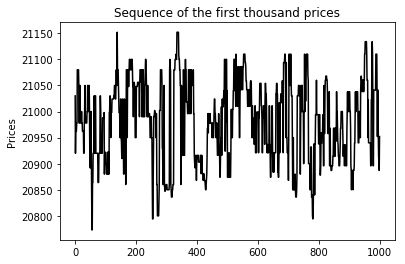

In [4]:
P = dp.extract_prices('trace.dat')['VAASM']
plt.plot(P[1][:1000], 'k-')
plt.ylabel('Prices')
plt.title('Sequence of the first thousand prices')
plt.show()

## DAT Informed Fundamentalist (DAT-IF)

In [5]:
class DAT_IF(Trader):
	def __init__(self, market, aggressiveness, information_level, self_confidence, initial_assets=None, cash=0):
		Trader.__init__(self, market, initial_assets, cash)
		self.alpha = aggressiveness
		self.iota = information_level
		self.kappa = self_confidence
	def __str__(self):
		return "DAT_IF %i" % self.trader_id
	def compute_fv(self, m, D):
		if self.iota > 0:
			iota = len(D)
			self.fv = int(round(sum([D[j]/((1+r)**j) for j in range(iota-1)]) + D[iota-1]/(r*(1+r)**(iota-2))))
	def decide_order(self, market, asset):
		p = market.prices[asset]
		m = self.fv if self.iota > 0 else p
		# On va calculer le prix et la direction de l'ordre qu'enverrait l'agent s'il était fondamentaliste
		best_ask = market.orderbooks[asset].asks.root().price if market.orderbooks[asset].asks.size > 0 else None
		best_bid = market.orderbooks[asset].bids.root().price if market.orderbooks[asset].bids.size > 0 else None
		if best_ask != None and best_ask <= m:
			fund_dir = 'BID' ; fund_price = best_ask
		elif best_bid != None and best_bid >= m:
			fund_dir = 'ASK' ; fund_price = best_bid
		else:
			best_ask = best_ask if best_ask != None else p
			best_bid = best_bid if best_bid != None else p
			if m-best_bid > best_ask-m:
				fund_dir = 'BID'
				fund_price = int(round(best_bid + self.alpha*(m-best_bid)))
			elif m-best_bid < best_ask-m:
				fund_dir = 'ASK'
				fund_price = int(round(best_ask + self.alpha*(m-best_ask)))
			else:
				fund_dir = None ; fund_price = None
		return None if fund_dir == None else LimitOrder(asset, self, fund_dir, fund_price, self.kappa)

Un `DAT-IF` a les mêmes attributs qu'un `DAT-F`, à l'exception qu'on ne lui donne pas une estimation de la valeur fondamentale (qu'il calcule) mais un niveau d'information.

In [6]:
# Création du marché

opening_price = 21000
nb_days = 50
nb_ticks = 10
r = .05 #risk-adjusted interest rate
file = open('trace.dat', 'w')
m = Market(['VAASM'], out=file, trace=['price'], init_price=opening_price, fix='L')

# Création des agents

for a in linspace(0, 1, 6):
    for i in range(0, 10):
        for k in [1, 3, 5, 7, 9]:
            t = DAT_IF(m, a, i, k, [1000000//opening_price], 1000000)
            t.init_wealth = t.get_wealth(m)
            m.add_trader(t)

# Calcul des dividendes futurs

d = 1000 ; D = [d]
for i in range(nb_days-1):
    d = round(normal(d, 10), 2)
    D.append(d)


# On fait tourner le marché jour par jour...
for d in range(nb_days):
    m.write('Day;\n')
    if d%10 == 0:    
        print('\tDay %i'%d)
    # On màj l'info dont disposent les traders
    for i, ag in enumerate(m.traders):
        D_ag = []
        for j in range(min(ag.iota, nb_days-d)):
            D_ag.append(round(D[d+j]*uniform(1-sqrt((j+1))*(10-ag.iota)/300, 1+sqrt((j+1))*(10-ag.iota)/300), 2))
        ag.compute_fv(m, D_ag)
    # On simule les ticks qui constituent le jour actuel
    for t in range(nb_ticks):
        m.run_once(shuffle=True)
    # On verse les dividendes
    for ag in m.traders:
        ag.add_cash(int(D[d]*ag.assets['VAASM']))

file.close()

	Day 0
	Day 10
	Day 20
	Day 30
	Day 40


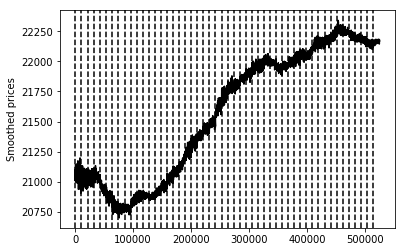

In [10]:
Prices = dp.extract_prices('trace.dat')
Prices = []
j = 0
with open('trace.dat', 'r') as file:
	for line in file:
		l = line.split(';')
		if l[0] == "Price":
			Prices.append(int(l[4]))
			j += 1
		elif l[0] == "Day":
			plt.axvline(j, color='k', ls='--') # On trace une ligne verticale à chaque début de jour
plt.plot(dp.smooth(Prices, 100), '-k')
plt.ylabel("Smoothed prices")
plt.show()

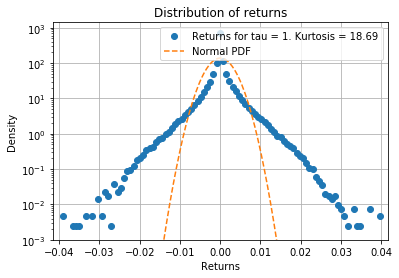

In [11]:
# On affiche la densité des rentabilités, lues dans le fichier trace.dat,
# pour le titre 'VAASM', et on affiche 100 points.
dp.draw_returns_hist('trace.dat', 'VAASM', 100)

## DAT Informed Fundamentalist & Chartist (DAT-IFC)

In [8]:
# On définit la fonction psi dont on sert dans la méthode decide
def psi(d):
	return 0 if d == None else (1 if d == 'ASK' else -1)
q0 = 10

class DAT_IFC(Trader):
	def __init__(self, market, aggressiveness, information_level, trend_flip, chartist_behavior, initial_assets=None, cash=0):
		Trader.__init__(self, market, initial_assets, cash)
		self.alpha = aggressiveness
		self.iota = information_level
		self.tau = chartist_behavior
		self.phi = trend_flip # 1 = trend will flip ; 0 = trend will keep going
	def __str__(self):
		return "DAT-IFC %i" % self.trader_id
	def compute_fv(self, m, D):
		if self.iota > 0:
			iota = len(D)
			self.fv = int(round(sum([D[j]/((1+r)**j) for j in range(iota-1)]) + D[iota-1]/(r*(1+r)**(iota-2))))
	def decide_order(self, market, asset):
		M_inf = 10
		M_sup = 30
		p = market.prices[asset]
		m = self.fv if self.iota > 0 else p
		# On va calculer le prix et la direction de l'ordre qu'enverrait l'agent s'il était fondamentaliste
		best_ask = market.orderbooks[asset].asks.root().price if market.orderbooks[asset].asks.size > 0 else None
		best_bid = market.orderbooks[asset].bids.root().price if market.orderbooks[asset].bids.size > 0 else None
		if best_ask != None and best_ask <= m:
			fund_dir = 'BID' ; fund_price = best_ask
		elif best_bid != None and best_bid >= m:
			fund_dir = 'ASK' ; fund_price = best_bid
		else:
			best_ask = best_ask if best_ask != None else p
			best_bid = best_bid if best_bid != None else p
			if m-best_bid > best_ask-m:
				fund_dir = 'BID'
				fund_price = int(round(best_bid + self.alpha*(m-best_bid)))
			elif m-best_bid < best_ask-m:
				fund_dir = 'ASK'
				fund_price = int(round(best_ask + self.alpha*(m-best_ask)))
			else:
				fund_dir = None ; fund_price = None
		# On va calculer le prix et la direction de l'ordre qu'enverrait l'agent s'il était chartist
		if len(market.prices_hist[asset]) >= M_sup:
			p_old = mean(market.prices_hist[asset][-M_sup:])
			p_new = mean(market.prices_hist[asset][-M_inf:])
			if p_new != p_old:
				if self.phi == 0: # Si l'agent pense que la tendance va persister
					chart_dir = 'BID' if p_new > p_old else 'ASK'
					chart_price = p_new + self.alpha*(p_new - p_old)
				else: # Si l'agent pense que la tendance va s'inverser
					chart_dir = 'ASK' if p_new > p_old else 'BID'
					chart_price = p_new + self.alpha*(p_old - p_new)
			else:
				chart_dir = None ; chart_price = None
		else:
			chart_dir = None ; chart_price = None
		# Maintenant, on va faire la moyenne de ces ordres...
		psi_d = (1-self.tau)*psi(fund_dir) + self.tau*psi(chart_dir)
		d = None if psi_d == 0 else ('ASK' if psi_d > 0 else 'BID')
		if d != None:
			# Si les ordres donnent des directions contraires, on va prendre le prix de celui qui a la direction égale à la direction finale
			if d == chart_dir and d != fund_dir:
				p = chart_price
			elif d == fund_dir and d != chart_dir:
				p = fund_price
			# Si les deux ordres ont donné la même direction, on fait une moyenne des deux prix
			elif d == fund_dir and d == chart_dir:
				p = int(round((1-self.tau)*fund_price + self.tau*chart_price))
			else:
				print("WTF")
			# Puis on calcule la quantité
			q = max(1, int(round(abs(psi_d)*q0)))
		return None if d == None else LimitOrder(asset, self, d, p, q)

Un `DAT-IFC` a pour attributs (supplémentaires) une aggressivité $\alpha \in [0,~1]$, un niveau d'information $\iota \in [\![0,~9]\!]$, une interprétation de la tendance des prix $\varphi\in\{0,~1\}$ et une proportion de chartist behavior $\tau \in [0,~1]$.

**Attention, la simulation suivante est assez longue (de l'ordre de la minute), mais c'est nécessaire pour avoir une courbe des wealth qui ait un sens : il faut que le nombre de jours soit assez grand (au moins 50). En outre, il faut que `M_sup` (définit en première ligne de la méthode `decide`) soit égal au nombre de jours.**

In [9]:
# On créé le marché comme avant

opening_price = 21000
nb_days = 50
nb_ticks = 10
r = .05 #risk-adjusted interest rate
file_ret = open('trace_returns.dat', 'w')
file = open('trace.dat', 'w')
m = Market(['VAASM'], out=file, trace=['price'], init_price=opening_price, fix='L')

# On créé nos agents

for tf in range(0, 2):
    for a in linspace(0, 1, 6):
        for i in range(0, 10):
            for cb in linspace(0, 1, 11):
                t = DAT_IFC(m, a, i, tf, cb, [1000000//opening_price], 1000000)
                t.init_wealth = t.get_wealth(m)
                m.add_trader(t)

# On calcule les dividendes futurs

d = 1000 ; D = [d]
for i in range(nb_days-1):
    d = round(normal(d, 10), 2)
    D.append(d)


# On fait tourner le marché...

for d in range(nb_days):
    m.write('Day;\n')
    if d%10 == 0:
        print('\tDay %i'%d)
    # On màj l'info dont disposent les traders
    for i, ag in enumerate(m.traders):
        D_ag = []
        for j in range(min(ag.iota, nb_days-d)):
            D_ag.append(round(D[d+j]*uniform(1-sqrt((j+1))*(10-ag.iota)/300, 1+sqrt((j+1))*(10-ag.iota)/300), 2))
        ag.compute_fv(m, D_ag)
    for t in range(nb_ticks):
        m.run_once()
    # On verse les dividendes
    for ag in m.traders:
        ag.add_cash(int(D[d]*ag.assets['VAASM']))

# Une fois la simulation finie, on calcule les rentabilités des agents
# (taux d'accroissement entre le wealth initial et le wealth final)
for ag in m.traders:
    file_ret.write("%i,%.1f,%i,%.2f\n" % (ag.iota, ag.tau, ag.phi, (ag.get_wealth(m)-ag.init_wealth)/ag.init_wealth))

file.close()
file_ret.close()

	Day 0
	Day 10
	Day 20
	Day 30
	Day 40


In [ ]:
Iota = [] ; Tau = [] ; Wealth = []
with open('trace_returns.dat', 'r') as file:
	for line in file:
		l = line.split(',')
		Iota.append(float(l[0]))
		Tau.append(float(l[1]))
		Wealth.append(float(l[3]))

Iota_ar = [round(x, 1) for x in range(0, 10)]
Tau_ar = [round(x, 1) for x in np.linspace(0, 1, 11)]
Wealth_mean = dict()
Wealth_std = dict()
Wealth_min = dict()
Wealth_max = dict()


for i in Iota_ar:
	for t in Tau_ar:
		Wealth_mean[(i, t)] = []
for j in range(len(Iota)):
	Wealth_mean[(Iota[j], Tau[j])].append(Wealth[j])
for i in Iota_ar:
	for t in Tau_ar:
		Wealth_std[(i,t)] = None if Wealth_mean[(i,t)] == [] else np.std(Wealth_mean[(i,t)])
		Wealth_min[(i,t)] = None if Wealth_mean[(i,t)] == [] else min(Wealth_mean[(i,t)])
		Wealth_max[(i,t)] = None if Wealth_mean[(i,t)] == [] else max(Wealth_mean[(i,t)])
		Wealth_mean[(i,t)] = None if Wealth_mean[(i,t)] == [] else np.mean(Wealth_mean[(i,t)])

X = [Iota_ar[i] for i in range(len(Iota_ar)) for t in range(len(Tau_ar))]
Y = [Tau_ar[t] for i in range(len(Iota_ar)) for t in range(len(Tau_ar))]
Z = [Wealth_mean[Iota_ar[i], Tau_ar[t]] for i in range(len(Iota_ar)) for t in range(len(Tau_ar))]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=-np.array(Z), marker='o', depthshade=False)
ax.set_xlabel('Information level ($\\iota$)')
ax.set_ylabel('Chartist behavior ($\\tau$)')
ax.set_zlabel('Returns ($r$)')
plt.show()